#This is just a side script that was used to generate a figure for the report

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.4MB/s]


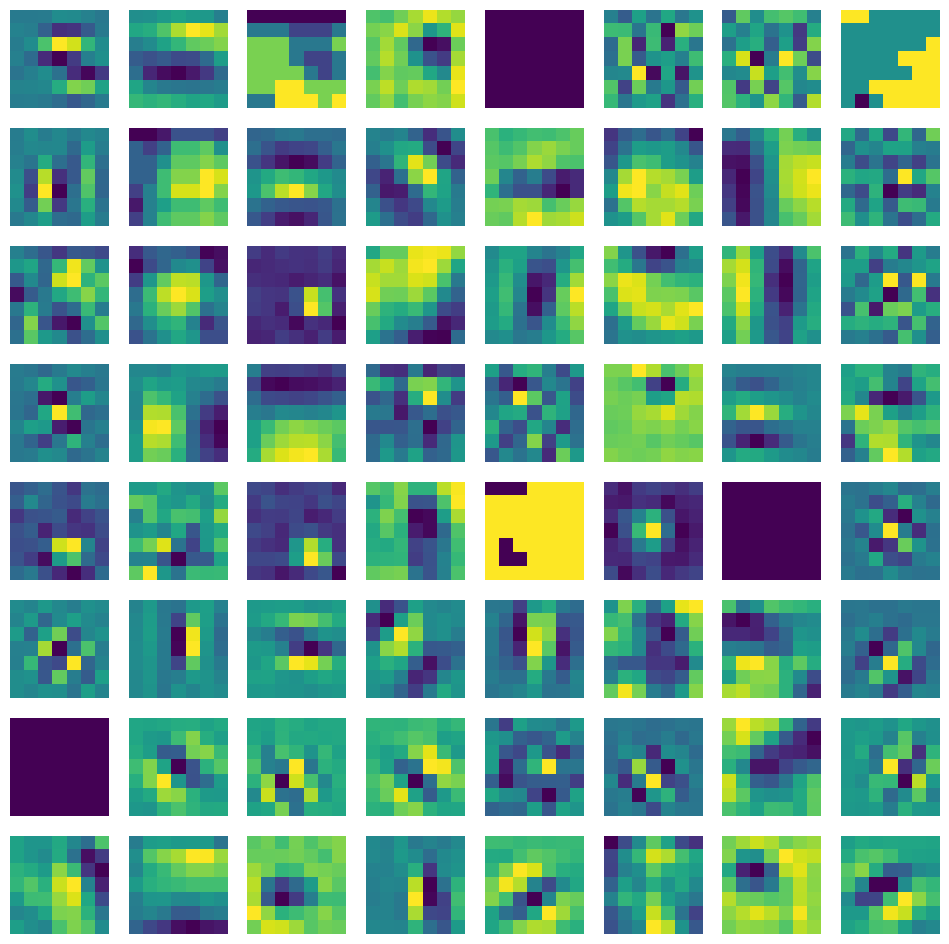

In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load a pretrained model (e.g., ResNet18) or your own model
model = models.resnet18(pretrained=True)

# Access the first convolutional layer
first_conv_layer = model.conv1

# Extract the weights (kernels)
kernels = first_conv_layer.weight.data.cpu().numpy()

# Normalize the kernels for better visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

# Plot the kernels
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < kernels.shape[0]:
        # Each kernel has 3 channels (RGB), so we average them for visualization
        kernel = kernels[i, :, :, :].mean(axis=0)
        ax.imshow(kernel, cmap='viridis')
    ax.axis('off')

plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


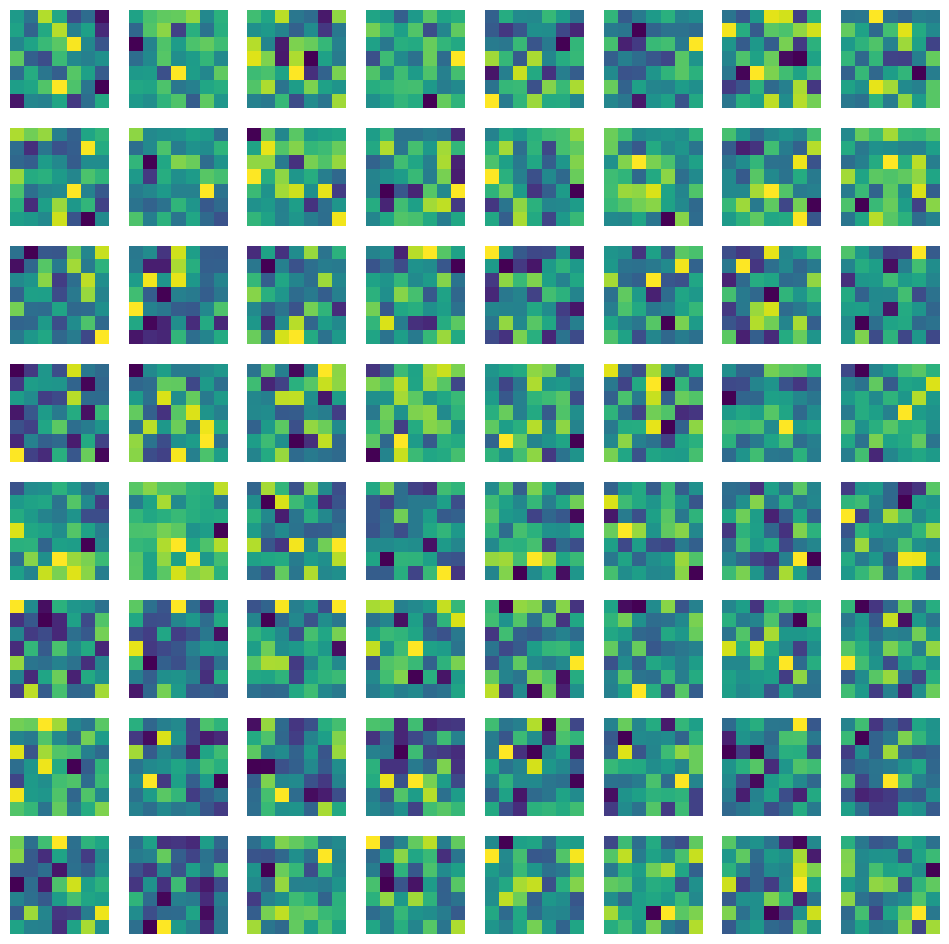

In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Load a pretrained model (e.g., ResNet18) or your own model
model = models.resnet18(pretrained=False)

# Access the first convolutional layer
first_conv_layer = model.conv1

# Extract the weights (kernels)
kernels = first_conv_layer.weight.data.cpu().numpy()

# Normalize the kernels for better visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

# Plot the kernels
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < kernels.shape[0]:
        # Each kernel has 3 channels (RGB), so we average them for visualization
        kernel = kernels[i, :, :, :].mean(axis=0)
        ax.imshow(kernel, cmap='viridis')
    ax.axis('off')

plt.show()


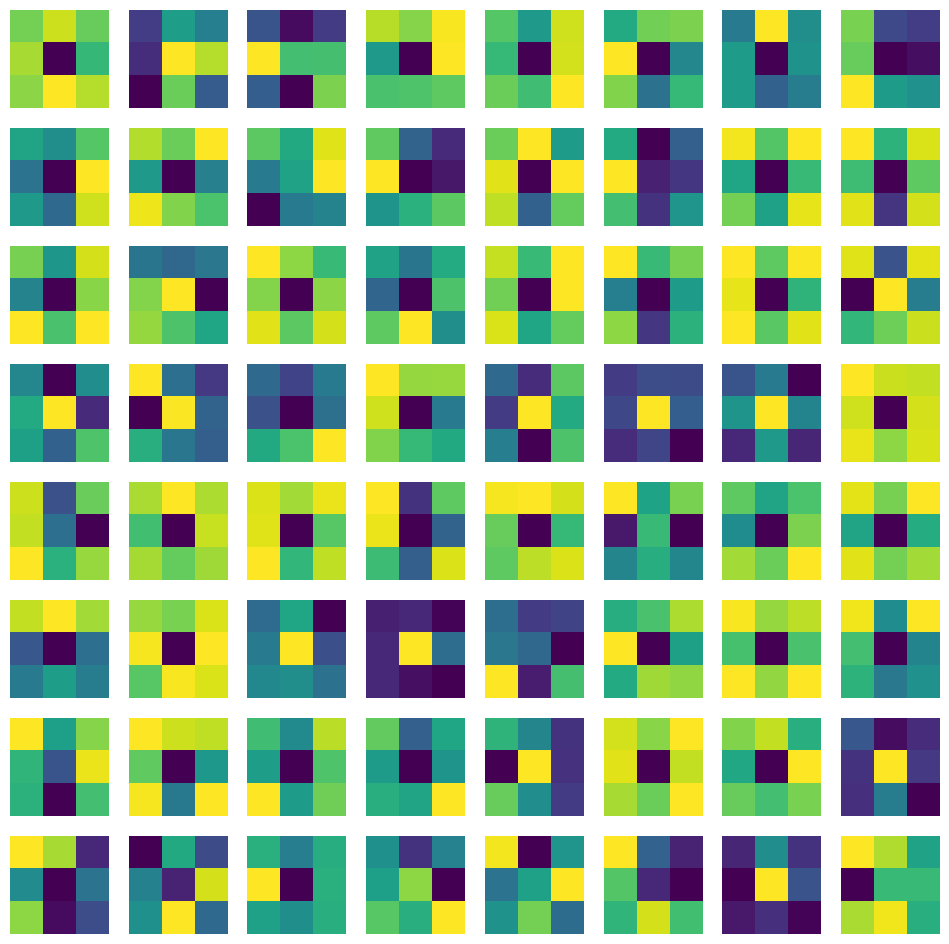

In [ ]:
first_conv_layer = model.layer1[0].conv1
# Extract the weights (kernels)
kernels = first_conv_layer.weight.data.cpu().numpy()

# Normalize the kernels for better visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

# Plot the kernels
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < kernels.shape[0]:
        # Each kernel has 3 channels (RGB), so we average them for visualization
        kernel = kernels[i, :, :, :].mean(axis=0)
        ax.imshow(kernel, cmap='viridis')
    ax.axis('off')

plt.show()

#Getting License plates from the images to be used for OCR


In [1]:
!pip install roboflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 737.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
from torchvision import transforms as T
from torch.utils.data import DataLoader, TensorDataset, Dataset
import json
from collections import defaultdict
import pandas as pd
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
import random



In [13]:
CLASS_COLORS = {
    "1": 'r',
    "2": 'w',
}
CLASS_NAMES ={
    "1": "Car",
    "2": "Plate"
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-1 in coco:: 100%|██████████| 2126/2126 [00:01<00:00, 2084.01it/s]


In [5]:
# # Define paths to your dataset folders
train_folder = "License-Plate-Detector---no-brand-1/train/"
test_folder = "License-Plate-Detector---no-brand-1/test/"
val_folder = "License-Plate-Detector---no-brand-1/valid/"

# # Get list of all image files in the images folder
def extract_file_paths(dir):
  json_file = ''
  for f in os.listdir(dir):
    if f.endswith('.json'):
      json_file = dir+f
  return json_file

train_label_file = extract_file_paths(train_folder)
val_label_file = extract_file_paths(val_folder)
test_label_file = extract_file_paths(test_folder)

train_label_file, test_label_file

('License-Plate-Detector---no-brand-1/train/_annotations.coco.json',
 'License-Plate-Detector---no-brand-1/test/_annotations.coco.json')

In [6]:
def extract_image_paths(dir):
  image_files = []
  for f in os.listdir(dir):
    if f.endswith('.jpg'):
      image_files.append(dir+f)

  return image_files

train_image_files = extract_image_paths(train_folder)
val_image_files = extract_image_paths(val_folder)
test_image_files = extract_image_paths(test_folder)

train_image_files[:5]

['License-Plate-Detector---no-brand-1/train/064a8def3049d040_jpg.rf.73336831a56c33d7ee72663fa6c86cc8.jpg',
 'License-Plate-Detector---no-brand-1/train/43b1b0028dd2db8d_jpg.rf.e253a396f06893b88e216a739b8c0109.jpg',
 'License-Plate-Detector---no-brand-1/train/65e080f9ac466664_jpg.rf.ff0b1ec4effe993a8aef90a188a1ce09.jpg',
 'License-Plate-Detector---no-brand-1/train/IMG_0428_JPG.rf.244f009946e59b0a741a04cb8d5a1db7.jpg',
 'License-Plate-Detector---no-brand-1/train/9498d0aff8f9ff8c_jpg.rf.a983fe9170b5c783a3f266f4d7547f4f.jpg']

In [7]:
# Opens annotation file
def extract_annotations(label_file):
  f= open(label_file)
  anns =json.load(f)
  return anns

train_anns = extract_annotations(train_label_file)
test_anns = extract_annotations(test_label_file)
val_anns = extract_annotations(val_label_file)

In [8]:
train_anns['annotations'][5], train_anns['categories'], train_anns['images'][0]

({'id': 5,
  'image_id': 2,
  'category_id': 1,
  'bbox': [30, 15, 574, 599],
  'area': 343826,
  'segmentation': [],
  'iscrowd': 0},
 [{'id': 0, 'name': '-cars--h9y9', 'supercategory': 'none'},
  {'id': 1, 'name': 'Car', 'supercategory': '-cars--h9y9'},
  {'id': 2, 'name': 'Plate', 'supercategory': '-cars--h9y9'}],
 {'id': 0,
  'license': 1,
  'file_name': '66771a4870c324f9_jpg.rf.6425aa11a8cdefeaa4caa569a8fa394a.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2024-07-10T17:45:52+00:00'})

In [9]:
def create_dfs(dir, anns):
  img_df = pd.DataFrame(anns['images'])
  img_df.drop(['height', 'width', 'date_captured', 'license'],axis=1, inplace=True)
  img_df['file_name'] = dir+img_df['file_name']

  ann_df = pd.DataFrame(anns['annotations'])
  ann_df.drop(['segmentation', 'iscrowd', 'area'], axis=1, inplace=True)
  # Extracting bbox values and creating new columns
  ann_df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(ann_df['bbox'].tolist(), index=ann_df.index)
  ann_df['x2'] = ann_df['x1'] + ann_df['w']
  ann_df['y2'] = ann_df['y1'] + ann_df['h']

  ann_df.drop(['w', 'h', 'bbox'], axis=1, inplace=True)

  return img_df, ann_df

In [10]:
train_img_df, train_ann_df = create_dfs(train_folder,train_anns)
test_img_df, test_ann_df = create_dfs(test_folder,test_anns)
val_img_df, val_ann_df = create_dfs(val_folder,val_anns)


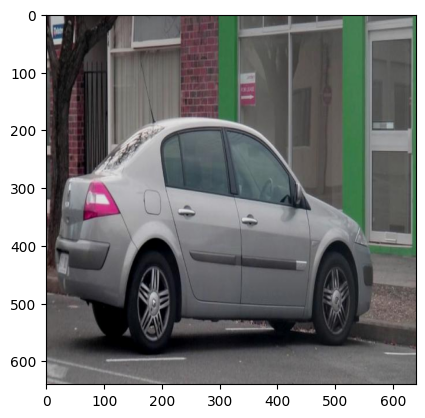

In [11]:
def plot_image_from_df(file_path):
  img = Image.open(file_path)
  fig, ax = plt.subplots()
  ax.imshow(img)
  plt.show()

img_id = 21
plot_image_from_df(train_img_df['file_name'][train_img_df['id'] ==img_id][img_id])

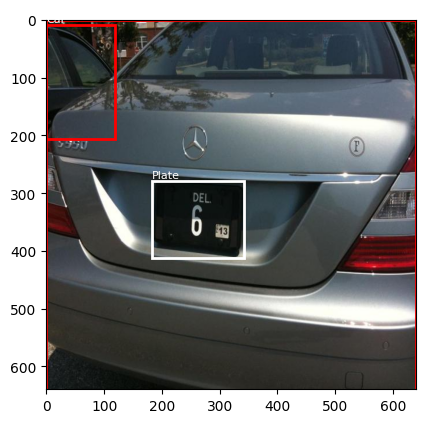

In [28]:
# Function to plot image with bounding boxes
def plot_image_with_annotations(image_id, img_df, ann_df):
    # Get the file path of the image
    image_path = img_df.loc[img_df['id'] == image_id, 'file_name'].values[0]

    # Load the image
    image = Image.open(image_path)

    # Extract annotations for the given image_id
    annots = ann_df[ann_df['image_id'] == image_id]
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes
    for _, row in annots.iterrows():
        rect = patches.Rectangle((row['x1'], row['y1']), row['x2'] - row['x1'], row['y2'] - row['y1'], linewidth=2, edgecolor=CLASS_COLORS[str(int(row['category_id']))], facecolor='none')

        ax.add_patch(rect)
        class_name = CLASS_NAMES[str(int(row['category_id']))]
        ax.text(row['x1'], row['y1'] - 5, class_name, color='white', fontsize=8)


    plt.show()

# Plot the image with id=0
plot_image_with_annotations(0, test_img_df, test_ann_df)

In [34]:
len(val_img_df), len(test_img_df), len(val_img_df) + len(test_img_df)

(128, 64, 192)

In [21]:
image_id = 1
annots = train_ann_df[train_ann_df['image_id'] == image_id]
boxes = annots[['x1', 'y1', 'x2', 'y2']].values
labels = annots['category_id'].values
boxes,labels

(array([[199., 130., 532., 419.],
        [334., 341., 436., 375.]]),
 array([1, 2]))

In [37]:
test_ann_df.head()

,id,image_id,category_id,x1,y1,x2,y2
0,0,0,2,183,279,342.5,411.5
1,1,0,1,0,8,118.0,206.5
2,2,0,1,0,0,640.0,640.0
3,3,1,2,403,390,560.0,456.5
4,4,1,1,150,0,640.0,624.0


In [38]:
 test_img_df.head()

,id,file_name
0,0,License-Plate-Detector---no-brand-1/test/c274e...
1,1,License-Plate-Detector---no-brand-1/test/cdb1e...
2,2,License-Plate-Detector---no-brand-1/test/bf0aa...
3,3,License-Plate-Detector---no-brand-1/test/b6e55...
4,4,License-Plate-Detector---no-brand-1/test/ccc1a...


In [45]:
merged_df = pd.merge(val_ann_df, val_img_df, left_on='image_id', right_on='id')
merged_df.head()

,id_x,image_id,category_id,x1,y1,x2,y2,id_y,file_name
0,0,0,1,0,58,115.0,154.5,0,License-Plate-Detector---no-brand-1/valid/IMG_...
1,1,0,1,92,65,451.5,412.0,0,License-Plate-Detector---no-brand-1/valid/IMG_...
2,2,0,1,363,68,640.0,281.0,0,License-Plate-Detector---no-brand-1/valid/IMG_...
3,3,0,2,260,323,379.5,357.0,0,License-Plate-Detector---no-brand-1/valid/IMG_...
4,4,0,2,594,221,640.0,237.0,0,License-Plate-Detector---no-brand-1/valid/IMG_...


In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [46]:
save_dir = '/content/gdrive/My Drive/MSc Project/Plate Images'
for index, row in merged_df.iterrows():
  if row['category_id'] == 2:
      # Open the image
      img = Image.open(row['file_name'])

      # Get the bounding box coordinates
      x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

      # Crop the image
      cropped_img = img.crop((x1, y1, x2, y2))

      # Create a new filename for the cropped image
      new_filename = os.path.join(save_dir, f"plate_{row['id_x']+198}.jpg")

      # Save the cropped image
      cropped_img.save(new_filename)


In [51]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,050 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:14 https://r2u.stat.illinois.edu

In [52]:
import os
import pandas as pd
from PIL import Image
import pytesseract

# Ensure tesseract executable is in your PATH, or specify the path directly
# pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'  # Update with your Tesseract path if necessary

# Directory containing the images
# directory = "/content/drive/My Drive/your_directory"  # Change this to your directory path

# List all image files in the directory
file_paths = []
for root, dirs, files in os.walk(save_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):  # Add other image extensions if needed
            file_paths.append(os.path.join(root, file))

# Function to perform OCR on an image and return detected text
def ocr_image(image_path):
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        return text.strip()  # Remove leading/trailing whitespaces
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return ""

# Create a DataFrame with "image paths" and OCR annotations
df = pd.DataFrame(file_paths, columns=["image paths"])
df["annotations"] = df["image paths"].apply(ocr_image)

# Save the DataFrame to a CSV file (optional)
df.to_csv("/content/gdrive/My Drive/MSc Project/OCR_Plate_Data.csv", index=False)

# Display the DataFrame
print(df)


                                           image paths annotations
0    /content/gdrive/My Drive/MSc Project/Plate Ima...         wae
1    /content/gdrive/My Drive/MSc Project/Plate Ima...            
2    /content/gdrive/My Drive/MSc Project/Plate Ima...            
3    /content/gdrive/My Drive/MSc Project/Plate Ima...            
4    /content/gdrive/My Drive/MSc Project/Plate Ima...            
..                                                 ...         ...
194  /content/gdrive/My Drive/MSc Project/Plate Ima...            
195  /content/gdrive/My Drive/MSc Project/Plate Ima...            
196  /content/gdrive/My Drive/MSc Project/Plate Ima...            
197  /content/gdrive/My Drive/MSc Project/Plate Ima...            
198  /content/gdrive/My Drive/MSc Project/Plate Ima...            

[199 rows x 2 columns]


In [47]:
import os
import pandas as pd
file_paths = []
for root, dirs, files in os.walk(save_dir):
    for file in files:
        file_paths.append(os.path.join(root, file))

# Create a DataFrame
df = pd.DataFrame(file_paths, columns=["image paths"])

# Assuming the annotations are in a separate column, you can initialize it with empty strings
df["annotations"] = ""

# Save the DataFrame to a CSV file (optional)
df.to_csv("/content/gdrive/My Drive/MSc Project/OCR_Plate_Data.csv", index=False)

# Display the DataFrame
print(df)

                                           image paths annotations
0    /content/gdrive/My Drive/MSc Project/Plate Ima...            
1    /content/gdrive/My Drive/MSc Project/Plate Ima...            
2    /content/gdrive/My Drive/MSc Project/Plate Ima...            
3    /content/gdrive/My Drive/MSc Project/Plate Ima...            
4    /content/gdrive/My Drive/MSc Project/Plate Ima...            
..                                                 ...         ...
194  /content/gdrive/My Drive/MSc Project/Plate Ima...            
195  /content/gdrive/My Drive/MSc Project/Plate Ima...            
196  /content/gdrive/My Drive/MSc Project/Plate Ima...            
197  /content/gdrive/My Drive/MSc Project/Plate Ima...            
198  /content/gdrive/My Drive/MSc Project/Plate Ima...            

[199 rows x 2 columns]
